In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [25]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, Interval, distinct
from sqlalchemy.sql.expression import text


In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()
most_recent_date

# test = session.query(measurement.date).order_by(measurement.date.desc()).first()
# print(test)

'2017-08-23'

#### Inspect Measurement Table

In [10]:
# Inspect 
measurement_inspector = inspect(engine)
measurement_columns = measurement_inspector.get_columns('measurement')
for m_c in measurement_columns:
    print(m_c['name'], m_c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


#### Inspect Station Table

In [11]:
# Inspect 
station_inspector = inspect(engine)
station_columns = station_inspector.get_columns('station')
for s_c in station_columns:
    print(s_c['name'], s_c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


datetime64[ns]


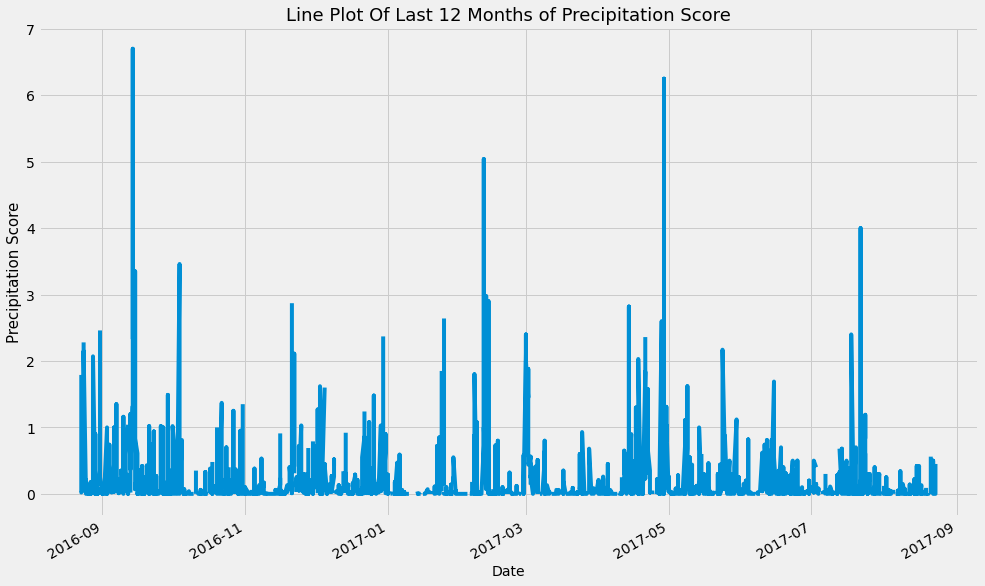

,date,score
0,2016-08-23,0.00
1009,2016-08-23,NaN
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15
...,...,...
1527,2017-08-22,0.00
1008,2017-08-23,0.00
360,2017-08-23,0.00
1528,2017-08-23,0.08


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

year_from_most_recent_date = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)
year_from_most_recent_date = year_from_most_recent_date.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores

prcp_score = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= year_from_most_recent_date) #.\
   # order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

prcp_score_df = pd.DataFrame(
    prcp_score, columns=['date', 'score']
)

# Sort the dataframe by date
prcp_score_df['date'] = pd.to_datetime(prcp_score_df.date)
prcp_score_df.sort_values('date', key=pd.to_datetime, inplace = True)
print(prcp_score_df.dtypes['date'])
# Use Pandas Plotting with Matplotlib to plot the data

graph, graph_axis = plt.subplots(figsize=(15,10))
graph_axis.plot(prcp_score_df["date"],
               prcp_score_df["score"])
graph_axis.set_title("Line Plot Of Last 12 Months of Precipitation Score", fontsize=18)
graph_axis.set_ylabel("Precipitation Score", fontsize=15);
graph_axis.set_xlabel("Date", fontsize=14);

graph.autofmt_xdate()
#plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
plt.show()


prcp_score_df


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_score_df.describe()

,score
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [141]:
# Design a query to calculate the total number stations in the dataset

# for row in session.query(station).all():
   # print(row.__dict__) 
# session.query(func.count(station.station)).scalar() 

session.query(func.count(distinct(station.station))).scalar()   

9

In [116]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
measurements_query = session.query(
    station.name, station.station, measurement.tobs, func.count(measurement.id)).\
    join(station, station.station == measurement.station).\
    group_by(station.name).\
    order_by(func.count(measurement.id).desc())

active_station_id = measurements_query.first().station
active_station_name = measurements_query.first().name

stations_df = pd.DataFrame(
    measurements_query, columns=['Station', 'id', 'temperature', 'Measurement Count']
)

print(f"\r\n Most Active Station is {active_station_name}({active_station_id})")

stations_df[['id', 'Station', 'Measurement Count']]


 Most Active Station is WAIHEE 837.5, HI US(USC00519281)


,id,Station,Measurement Count
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [117]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station_temp_stats = session.query(
    station.name, station.id, func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    join(station, station.station == measurement.station).\
    filter(station.station == active_station_id).all()

active_station_temp_stats_df = pd.DataFrame(
    active_station_temp_stats,
    columns = ["Station", "Id", "Lowest Temperature", "Highest Temperature", "Mean Temperature"]
)

active_station_temp_stats_df[["Station", "Lowest Temperature", "Highest Temperature", "Mean Temperature"]]

,Station,Lowest Temperature,Highest Temperature,Mean Temperature
0,"WAIHEE 837.5, HI US",54.0,85.0,71.663781



Most Active Station's (WAIHEE 837.5, HI US:USC00519281)  
most recent measurement was on 2017-08-18


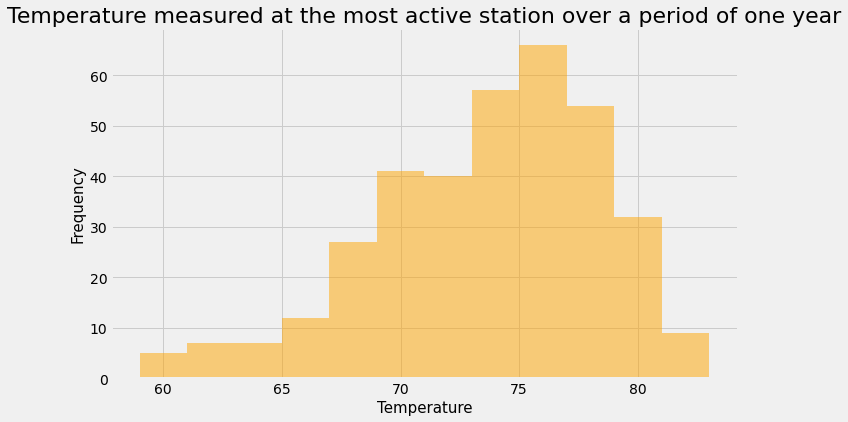

,date,Temperature
0,2016-08-18,80.0
1,2016-08-19,79.0
2,2016-08-20,81.0
3,2016-08-21,79.0
4,2016-08-22,78.0
...,...,...
352,2017-08-14,77.0
353,2017-08-15,77.0
354,2017-08-16,76.0
355,2017-08-17,76.0


In [142]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

active_station_most_recent_measurement_date = session.query(
        measurement.station, 
        func.max(measurement.date)).\
    filter(measurement.station == active_station_id).\
    first()

active_station_most_recent_measurement_date

print(f"""\r\nMost Active Station's ({active_station_name}:{active_station_id})  
most recent measurement was on {active_station_most_recent_measurement_date[1]}""")

analysis_start_date = pd.to_datetime(active_station_most_recent_measurement_date[1]) - pd.DateOffset(years=1)
analysis_start_date = analysis_start_date.strftime('%Y-%m-%d')

active_station_Last_one_year_temperature_measurements = session.query(measurement.date, measurement.tobs).\
    filter(
        measurement.date >= analysis_start_date,
        measurement.date <= active_station_most_recent_measurement_date[1],
        measurement.station == active_station_id).\
    order_by(measurement.date).all()

active_station_Last_one_year_temperature_measurements_df = pd.DataFrame(
    active_station_Last_one_year_temperature_measurements, columns=['date', 'Temperature']
)

chart, ax = plt.subplots(figsize=(10,6))
ax.hist(active_station_Last_one_year_temperature_measurements_df["Temperature"], bins=12, alpha=0.5, color='orange')
ax.set_title("Temperature measured at the most active station over a period of one year", fontsize=22)
ax.set_ylabel("Frequency", fontsize=15);
ax.set_xlabel("Temperature", fontsize=15);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

active_station_Last_one_year_temperature_measurements_df

# Close session

In [143]:
# Close Session
session.close()